# Differentially Private Point Patterns with GANs

## Setup

Install / load required dependencies

In [9]:
from IPython.display import clear_output
import torch
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import cuda, FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader

import datetime
import sys
import requests
import io
import os
import random
from time import sleep

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [10]:
# Use GPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Connect to GDrive

In [11]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [12]:
# !if [ -d 'gdrive/My Drive/PNGAN/model']; then echo "Directory train already exist" ; else mkdir -p 'gdrive/My Drive/PNGAN/model' && echo "Directory train created"; fi

## Data

Read data; Options are:
* `"porto"` (2D)
* `"new_york"` (2D)
* `"beijing"` (2D)
* `"3d_road"` (3D)

In [13]:
### CHOSE DATASET YOU WANT TO USE
dataset = "3d_road" # chose from ["porto","new_york,"beijing","3d_road"]
###

if dataset == "porto":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/porto-test.csv"
elif dataset == "new_york":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/nyc-test.csv"
elif dataset == "beijing":
  url="https://raw.githubusercontent.com/konstantinklemmer/konstantinklemmer.github.io/master/data/data_teddy/beijing-test.csv"
elif dataset == "3d_road":
  url="https://archive.ics.uci.edu/ml/machine-learning-databases/00246/3D_spatial_network.txt"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

if dataset == "3d_road":
  c.columns = ["id","x","y","z"]
  c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
  c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1
  c["z"] = 2 * (c["z"]-min(c["z"]))/(max(c["z"])-min(c["z"])) - 1
  c = c[["x","y","z"]]
else:
  c.columns = ["x","y"]
  c["x"] = 2 * (c["x"]-min(c["x"]))/(max(c["x"])-min(c["x"])) - 1
  c["y"] = 2 * (c["y"]-min(c["y"]))/(max(c["y"])-min(c["y"])) - 1

data_scaled = c

Plot data

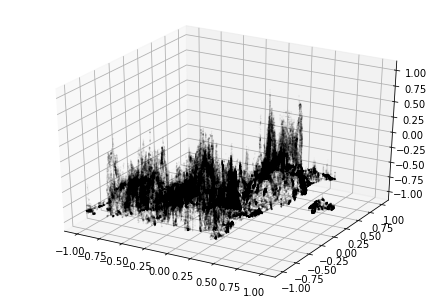

In [14]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

if dataset == "3d_road":
  fig = pyplot.figure()
  ax = Axes3D(fig)

  ax.scatter(c[["x"]],c[["y"]],c[["z"]], s = 0.001, c="black")

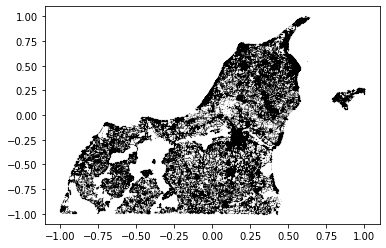

In [15]:
plt.scatter(c[["x"]],c[["y"]], s = 0.001, c="black")

### PointGAN - Code Base

In [16]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch.nn.functional as F


class STNkd(nn.Module):
    def __init__(self, num_points = 2500, k = 3):
        super(STNkd, self).__init__()
        self.num_points = num_points
        self.k = k
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        #self.mp1 = torch.nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        #x = self.mp1(x)
        #print(x.size())
        x,_ = torch.max(x, 2)
        #print(x.size())
        x = x.view(-1, 1024)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x


class PointNetfeat(nn.Module):
    def __init__(self, num_points = 2500, n_dim = 3, global_feat = True, trans = True):
        super(PointNetfeat, self).__init__()
        self.n_dim = n_dim
        self.stn = STNkd(num_points = num_points, k = n_dim)
        self.conv1 = torch.nn.Conv1d(n_dim, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)

        self.bn1 = torch.nn.BatchNorm1d(64)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.bn3 = torch.nn.BatchNorm1d(1024)
        self.trans = trans


        #self.mp1 = torch.nn.MaxPool1d(num_points)
        self.num_points = num_points
        self.global_feat = global_feat
    def forward(self, x):
        batchsize = x.size()[0]
        if self.trans:
            trans = self.stn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans)
            x = x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x,_ = torch.max(x, 2)
        x = x.view(-1, 1024)
        if self.trans:
            if self.global_feat:
                return x, trans
            else:
                x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
                return torch.cat([x, pointfeat], 1), trans
        else:
            return x

class PointNetCls(nn.Module):
    def __init__(self, num_points = 2500, n_dim = 2, k = 1):
        super(PointNetCls, self).__init__()
        self.num_points = num_points
        self.n_dim = n_dim
        self.k = k
        self.feat = PointNetfeat(num_points = num_points, n_dim = n_dim, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sig(x)
        return x, trans

class PointDecoder(nn.Module):
    def __init__(self, num_points = 2048, k = 2):
        super(PointDecoder, self).__init__()
        self.num_points = num_points
        self.k = k
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, self.num_points * self.k)
        self.th = nn.Tanh()
    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.th(self.fc5(x))
        x = x.view(batchsize, self.k, self.num_points)
        return x


class PointNetAE(nn.Module):
    def __init__(self, num_points = 2048, k = 2):
        super(PointNetAE, self).__init__()
        self.num_points = num_points
        self.encoder = nn.Sequential(
        PointNetfeat(num_points, global_feat=True, trans = False),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 100),
        )

        self.decoder = PointDecoder(num_points)



    def forward(self, x):

        x = self.encoder(x)

        x = self.decoder(x)

        return x


class PointNetReg(nn.Module):
    def __init__(self, num_points = 2500, k = 1):
        super(PointNetReg, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x):
        x, trans = self.feat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, trans



class PointNetReg2(nn.Module):
    def __init__(self, num_points = 500, k = 3):
        super(PointNetReg2, self).__init__()
        self.num_points = num_points
        self.feat = PointNetfeat(num_points, global_feat=True)
        self.fc1 = nn.Linear(1024 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100, k)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
    def forward(self, x1, x2):
        x1, trans1 = self.feat(x1)
        x2, trans2 = self.feat(x2)

        x = torch.cat([x1,x2], 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)

        return x, trans1, trans2



class PointNetDenseCls(nn.Module):
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k))
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans


class PointGen(nn.Module):
    def __init__(self, num_points = 2500, n_dim = 3):
        super(PointGen, self).__init__()
        self.num_points = num_points
        self.n_dim = n_dim
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, self.num_points * n_dim)

        self.th = nn.Tanh()
    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.th(self.fc4(x))
        x = x.view(batchsize, self.n_dim, self.num_points)
        return x

class PointGenComp(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenComp, self).__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 500 * 3)
        self.encoder = PointNetfeat(num_points = 2000)
        self.th = nn.Tanh()
    def forward(self, x, noise):
        batchsize = x.size()[0]
        x, _ = self.encoder(x)
        x = torch.cat([x, noise], 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.th(self.fc4(x))
        x = x.view(batchsize, 3, 500)
        return x

class PointGenComp2(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenComp2, self).__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 2500 * 3)
        self.encoder = PointNetfeat(num_points = 2000)
        self.th = nn.Tanh()
    def forward(self, x, noise):
        batchsize = x.size()[0]
        x, _ = self.encoder(x)
        x = torch.cat([x, noise], 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.th(self.fc4(x))
        x = x.view(batchsize, 3, 2500)
        return x


class PointGenR(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenR, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 500 * 3)
        self.lstm = nn.LSTM(input_size = 20, hidden_size= 100, num_layers = 2)
        self.th = nn.Tanh()


    def forward(self, x):
        batchsize = x.size()[1]
        x, _ = self.lstm(x)
        x = x.view(-1,100)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.th(self.fc4(x))

        x = x.view(5, batchsize, 1500)

        x = x.transpose(1,0).contiguous()
        x = x.view(batchsize, 7500)

        x = x.view(batchsize, 3, 2500)
        return x

class PointGenR2(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenR2, self).__init__()

        self.decoder = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 500 * 3),
        nn.Tanh(),
        )

        self.lstmcell =   nn.LSTMCell(input_size = 100, hidden_size= 100)

        self.encoder = nn.Sequential(
        PointNetfeat(num_points = 500),
        )
        self.encoder2 = nn.Sequential(
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 100),
        )


    def forward(self, x):
        batchsize = x.size()[0]
        outs = []
        out = self.decoder(x)
        out = out.view(batchsize, 3, 500)
        outs.append(out)

        hx = Variable(torch.zeros(batchsize, 100))
        cx = Variable(torch.zeros(batchsize, 100))
        if x.is_cuda:
            hx = hx.cuda()
            cx = cx.cuda()

        for i in range(4):
            hd,_ = self.encoder(outs[-1])
            hd = self.encoder2(hd)
            hx, cx = self.lstmcell(hd, (hx, cx))

            out = self.decoder(hx)
            out = out.view(batchsize, 3, 500)
            outs.append(out)


        x = torch.cat(outs, 2)

        return x



class PointGenR3(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenR3, self).__init__()

        def get_decoder():
            return nn.Sequential(
            nn.Linear(200, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 500 * 3),
            nn.Tanh(),
            )
        self.decoder = get_decoder()

        self.lstmcell =   nn.LSTMCell(input_size = 100, hidden_size= 100)

        self.encoder = nn.Sequential(
        PointNetfeat(num_points = 500),
        )
        self.encoder2 = nn.Sequential(
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512, 100),
        )


    def forward(self, x):
        batchsize = x.size()[0]

        hx = Variable(torch.zeros(batchsize, 100))
        cx = Variable(torch.zeros(batchsize, 100))

        outs = []

        if x.is_cuda:
            hx = hx.cuda()
            cx = cx.cuda()

        for i in range(5):
            if i == 0:
                hd = Variable(torch.zeros(batchsize, 100))
            else:
                hd,_ = self.encoder(torch.cat(outs, 2))
                hd = self.encoder2(hd)
            #print(hd.size())
            if x.is_cuda:
                hd = hd.cuda()

            hx, cx = self.lstmcell( hd, (hx, cx))

            out = self.decoder(torch.cat([hx,x[:,:,i]], 1))
            out = out.view(batchsize, 3, 500)
            outs.append(out)

        x = torch.cat(outs, 2)

        return x

class PointGenC(nn.Module):
    def __init__(self, num_points = 2500):
        super(PointGenC, self).__init__()
        self.conv1 = nn.ConvTranspose1d(100, 1024, 2,2,0)
        self.conv2 = nn.ConvTranspose1d(1024, 512, 5,5,0)
        self.conv3 = nn.ConvTranspose1d(512, 256, 5,5,0)
        self.conv4 = nn.ConvTranspose1d(256, 128, 2,2,0)
        self.conv5 = nn.ConvTranspose1d(128, 64, 5,5,0)
        self.conv6 = nn.ConvTranspose1d(64, 3, 5,5,0)

        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(512)
        self.bn3 = torch.nn.BatchNorm1d(256)
        self.bn4 = torch.nn.BatchNorm1d(128)
        self.bn5 = torch.nn.BatchNorm1d(64)
        self.th = nn.Tanh()
    def forward(self, x):

        batchsize = x.size()[0]
        x = x.view(-1, 100, 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.conv6(x)

        x = self.th(x)
        return x


class PointGenPSG(nn.Module):
    def __init__(self, num_points = 2048):
        super(PointGenPSG, self).__init__()
        self.num_points = num_points
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, self.num_points / 4 * 3 * 1)
        self.th = nn.Tanh()

        self.conv1 = nn.ConvTranspose2d(100,1024,(2,3))
        self.conv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.conv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.conv4= nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.conv5= nn.ConvTranspose2d(128, 3, 4, 2, 1)

        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.bn2 = torch.nn.BatchNorm2d(512)
        self.bn3 = torch.nn.BatchNorm2d(256)
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.bn5 = torch.nn.BatchNorm2d(3)



    def forward(self, x):
        batchsize = x.size()[0]

        x1 = x
        x2 = x

        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = F.relu(self.fc3(x1))
        x1 = self.th(self.fc4(x1))
        x1 = x1.view(batchsize, 3, self.num_points / 4 * 1)

        x2 = x2.view(-1, 100, 1, 1)
        x2 = F.relu((self.conv1(x2)))
        x2 = F.relu((self.conv2(x2)))
        x2 = F.relu((self.conv3(x2)))
        x2 = F.relu((self.conv4(x2)))
        x2 = self.th((self.conv5(x2)))

        x2 = x2.view(-1, 3, 32 * 48)
        #print(x1.size(), x2.size())

        return torch.cat([x1, x2], 2)

# if __name__ == '__main__':
#     sim_data = Variable(torch.rand(32,3,2500))
#     trans = STN3d()
#     out = trans(sim_data)
#     print('stn', out.size())

#     pointfeat = PointNetfeat(global_feat=True)
#     out, _ = pointfeat(sim_data)
#     print('global feat', out.size())

#     pointfeat = PointNetfeat(global_feat=False)
#     out, _ = pointfeat(sim_data)
#     print('point feat', out.size())

#     cls = PointNetCls(k = 5)
#     out, _ = cls(sim_data)
#     print('class', out.size())

#     seg = PointNetDenseCls(k = 3)
#     out, _ = seg(sim_data)
#     print('seg', out.size())

#     sim_data = Variable(torch.rand(32,3,500))
#     pointreg = PointNetReg2()
#     out, _, _ = pointreg(sim_data, sim_data)
#     print('reg2', out.size())

Utils

In [17]:
#Plotting
def get_sample_points(G, z, n_dim = 2):
    """
      Generate 'size' data samples
      ___

      G = Generator (in G.eval() mode)
      z = Random noise tensor of shape (n, 2, 1)
      n = number of points
    """
    z_gen = G(z)
    #z_gen = z_gen.permute(2,0,1)
    n = z_gen.shape[2]
    batch_size = z_gen.shape[0]
    y_hat = z_gen.reshape(n * batch_size, n_dim) 
    points = y_hat.cpu().data.numpy()
    return points

#Probability calculator with privacy budget
from math import e
def dp_proba(eps, d):
  p = (e**eps) / (e**eps + d - 1)
  q = 1 / (e**eps + d - 1)
  return p, q

## Training

Enter the desired training configuration

In [27]:
### TRAINING CONFIGURATION
torch.manual_seed(99) # Initiate random seed
# TRAINING DATA
draw_with_replacement = False #Draw with replacement or not
n_samples = 10000 # Number of random draws from the real points
num_points = 2500 # Number of drawn points
# TRAINING UTILITIES
enable_plotting = True # Plot GAN samples every 500 steps
save_model_step = False # Save models (D,G) to drive every 500 steps (requires mounted Google Drive)
warm_start = False # Continue training of existing models (requires mounted Google drive with models)
# TRAINING CONFIG
batch_size = 16 # Set batch size
embed_dim_d = 256 # Number of point embedding dimensions for Discriminator
embed_dim_g = 256 # Number of point embedding dimensions for Generator
d_train = 1 # How many more training steps for Discriminator than Generator (1 = equal training)
label_flip = True #Randomly flip GAN labels to train a DP Generator
eps = 2 #Define privacy budget (only if label_flip = True)
if dataset == "3d_road":
  n_dim = 3
else:
  n_dim = 2
###

Train GAN:

<Figure size 432x288 with 0 Axes>

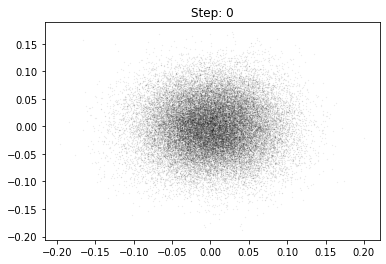

Epoch 1 [0/625] - G Loss: 0.646 - D Loss: 1.411
Epoch 1 [100/625] - G Loss: 0.738 - D Loss: 1.377
Epoch 1 [200/625] - G Loss: 0.679 - D Loss: 1.336


In [ ]:
%matplotlib inline

#Define training samples
total_num_points = len(data_scaled["x"]-1)
data = torch.zeros(n_samples,num_points,n_dim)
for i in range(n_samples-1):
  if draw_with_replacement:
    idx = np.random.randint(low=0,high=total_num_points, size=num_points) # Draw with replacement
  else:
    idx = np.random.choice(total_num_points, num_points) # Draw without replacement
  sample = data_scaled.iloc[idx]
  sample = sample.to_numpy().reshape(num_points,n_dim)
  data[i,:,:] = torch.tensor(sample)
train_data = torch.tensor(data)

#Define DP probabilities
p, q = dp_proba(eps, 2)

# Define G and D
if warm_start:
  D = torch.load('gdrive/My Drive/PNGAN/model/D.pkl.gz')
  G = torch.load('gdrive/My Drive/PNGAN/model/G.pkl.gz')
else:
  D = PointNetCls(num_points = num_points, n_dim = n_dim, k = 1).to(DEVICE)
  G = PointGen(num_points = num_points, n_dim = n_dim).to(DEVICE)
# Loss criterion
criterion = nn.BCELoss()
# Initialize D and G optimizer
D_opt = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
# Define fake and real point labels
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_labels = D_labels - 0.1 # Can skip that line - Just a trick known to work well with GANs
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake
# Define data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

gen_loss = []
disc_loss = []
check_step = []
num_epochs = 5 # Number of training epochs
step = 0 # Initiate training step
g_step = 0
z_img = torch.randn(batch_size, 100).to(DEVICE) # Initialize random noise for generating images

for e in range(num_epochs):
  # Within each iteration, we will go over each minibatch of data
  for minibatch_i, (x_batch) in enumerate(train_loader):
    # Get data
    x = x_batch.float().to(DEVICE)
    x = x.permute(0,2,1)
    # Get labels
    if label_flip==True:
      D_labels = torch.bernoulli(torch.tensor([p] * batch_size)).reshape(batch_size,1).to(DEVICE)
      D_labels = D_labels - 0.1 # Can skip that line - Just a trick known to work well with GANs
      D_fakes = torch.bernoulli(torch.tensor([q] * batch_size)).reshape(batch_size,1).to(DEVICE)
    #Train Discriminator
    for d in range(d_train): #Train Disc d_train steps over Generator
      x_outputs, _ = D(x)
      z = torch.randn(batch_size, 100).to(DEVICE)
      z_gen = G(z)
      z_outputs, _ = D(z_gen)
      D_x_loss = criterion(x_outputs, D_labels)
      D_z_loss = criterion(z_outputs, D_fakes)
      D_loss = D_x_loss + D_z_loss 
      D.zero_grad()
      D_loss.backward()
      D_opt.step()
    # Training Generator
    g_step += 1
    z = torch.randn(batch_size, 100).to(DEVICE)
    z_gen = G(z)
    z_outputs, _ = D(z_gen)
    G_z_loss = criterion(z_outputs, D_labels)
    G_loss = G_z_loss 
    G.zero_grad()
    G_loss.backward()
    G_opt.step()
    gen_loss.append(G_loss.item())
    disc_loss.append(D_loss.item())
    # Training utilities: Saving models, plotting and loss progression
    if save_model_step:
      if step % 500 == 0:
        torch.save(G, "gdrive/My Drive/PNGAN/model/G.pkl.gz")
        torch.save(D, "gdrive/My Drive/PNGAN/model/D.pkl.gz")
    if enable_plotting:
      if step % 500 == 0:
        with torch.no_grad():
          G.eval()
          exp_points = get_sample_points(G, z_img, n_dim)
          clear_output()
          plt.figure(0)
          fig = plt.figure()
          ax = fig.add_subplot(1, 1, 1)
          ax.scatter(exp_points[:,0],exp_points[:,1],s=0.1,alpha=0.1,c="black")
          ax.set_facecolor('white')
          ax.set_title('Step: %i' %step)
          plt.show()
          sleep(1)
          G.train()                    
    if step % 100 == 0:
      print('Epoch %d [%d/%d] - G Loss: %.3f - D Loss: %.3f' % (e + 1, minibatch_i, len(train_loader), G_loss.item(), D_loss.item()))
    step = step + 1

## Plotting checks:

How does the generated data look like at the last training step?

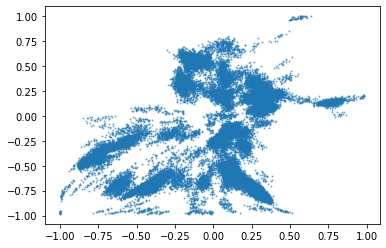

In [24]:
plt.scatter(z_gen[:,0,:].detach().cpu().reshape(-1),z_gen[:,1,:].detach().cpu().reshape(-1),s=1,alpha=0.5)

How does the real data look in comparison? Quite similar!

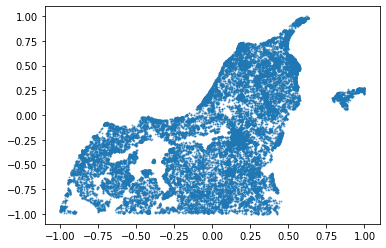

In [25]:
plt.scatter(x[:,0,:].detach().cpu().reshape(-1),x[:,1,:].detach().cpu().reshape(-1),s=1,alpha=0.5)

Let's check the model losses:

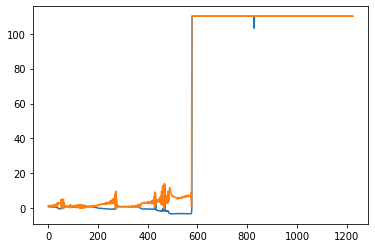

In [26]:
plt.plot(range(len(disc_loss)), disc_loss)
plt.plot(range(len(gen_loss)), gen_loss)